# CNN을 활용한 Recommendation

In [1]:
import pandas as pd
import numpy as np
import os


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

In [2]:
style = pd.read_csv('styles.csv', error_bad_lines=False, encoding = 'utf-8').dropna(how = 'any')

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [3]:
style['image'] = style.apply(lambda row: str(row['id']) + ".jpg", axis=1)
style = style.reset_index(drop=True)

In [4]:
style.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [5]:
dataset = 'images'
img_list = []

for img in os.listdir(dataset):
    img_list.append(img)

In [6]:
style = style.query('image in @img_list')
style.index = range(len(style))

## VGG16 활용

In [10]:
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(80,60,3))

base_model.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
final_model = Sequential()
final_model.add(base_model)

In [12]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 1, 512)         14714688  
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


## image 별 embedding 추출

In [18]:
def get_embedding(final_model, img_name):
    
    img = image.load_img(img_name, target_size=(img_width, img_height))
    x   = image.img_to_array(img)
    x   = np.expand_dims(x, axis=0)
    x   = preprocess_input(x)

    return final_model.predict(x).reshape(-1)

In [14]:
cd images

C:\Users\ksh\kaggle&Dacon\Kaggle\cnn_rec\images


In [23]:
%%time
import swifter

# Parallel apply
map_embeddings = style['image'].swifter.apply(lambda img: get_embedding(final_model, img))
style_embs = map_embeddings.apply(pd.Series)

print(style_embs.shape)
style_embs.head()


(44072, 1024)
Wall time: 58min 13s


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,27.875509,0.0,0.0,50.274231,0.0,0.0,0.0,0.0,46.061989
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,6.481296,0.0,0.0,0.0,0.0,8.919969
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,23.487926,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,72.365440
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,33.802902


## 코사인 유사도 계산

In [24]:
from sklearn.metrics.pairwise import pairwise_distances

cosine_sim = 1-pairwise_distances(style_embs, metric='cosine')
cosine_sim[:4, :4]

array([[0.99999976, 0.07244426, 0.07521832, 0.13025826],
       [0.07244426, 1.        , 0.12370956, 0.5997946 ],
       [0.07521832, 0.12370956, 1.        , 0.04724121],
       [0.13025826, 0.5997946 , 0.04724121, 1.        ]], dtype=float32)

In [141]:
indices = pd.Series(range(len(style)), index=style.index)
min_count = style.articleType.value_counts().index[style.articleType.value_counts() < 6]

def get_rec_idx(idx, df):
    cat = style.articleType[idx]
    if cat in style.articleType.value_counts().index[style.articleType.value_counts() < 6]:
        idx_rec = cosine_sim[idx].argsort()[-7 : -1][::-1]
        
        return indices.iloc[idx_rec].index
    else:
        cat_idx = style.loc[style.articleType == cat].index
        idx_rec = cat_idx[cosine_sim[idx][cat_idx].argsort()[-7 : -1]][::-1]

    
        return indices.iloc[idx_rec].index

get_rec_idx(5665, style)

Int64Index([36611, 8029, 33025, 4137, 40245, 5286], dtype='int64')

In [143]:
def plotting(figures, nrows = 1, ncols=1,figsize=(8, 8)):

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()

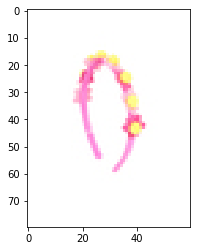

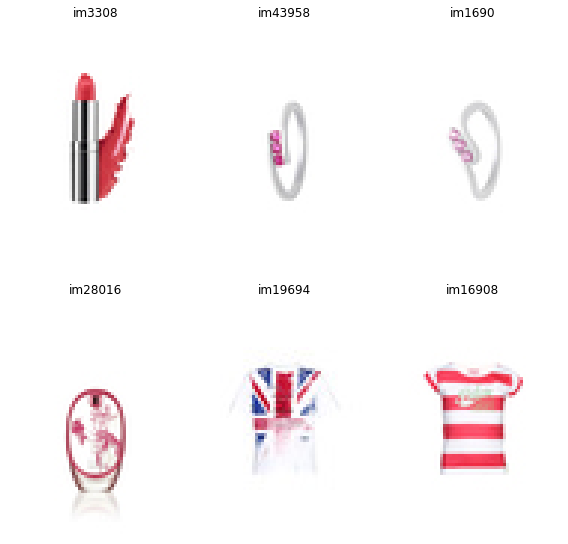

In [144]:
idx = 8691

idx_rec = get_rec_idx(idx,style)

plt.imshow(cv2.cvtColor(cv2.imread(style.iloc[idx].image), cv2.COLOR_BGR2RGB))

figures = {'im'+str(i): cv2.imread(row.image) for i, row in style.loc[idx_rec].iterrows()}

plotting(figures, 2, 3)

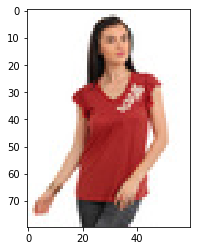

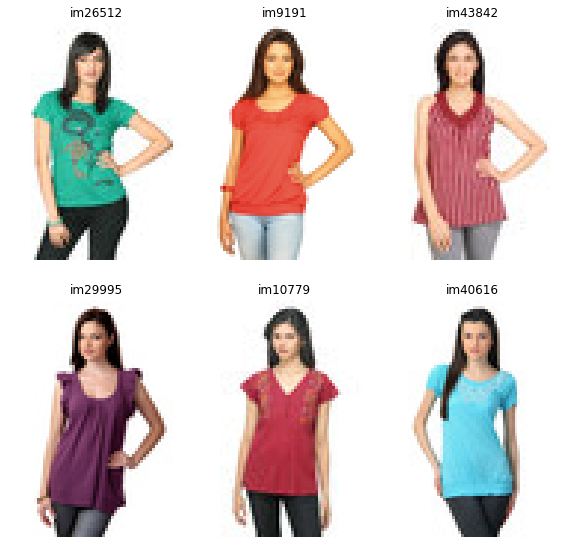

In [145]:
idx = 31235

idx_rec = get_rec_idx(idx,style)

plt.imshow(cv2.cvtColor(cv2.imread(style.iloc[idx].image), cv2.COLOR_BGR2RGB))

figures = {'im'+str(i): cv2.imread(row.image) for i, row in style.loc[idx_rec].iterrows()}

plotting(figures, 2, 3)

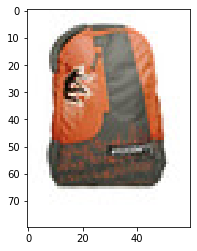

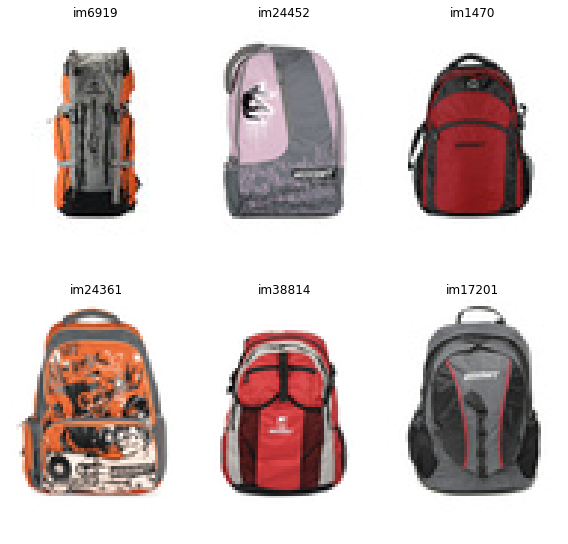

In [146]:
idx = 20187

idx_rec = get_rec_idx(idx,style)

plt.imshow(cv2.cvtColor(cv2.imread(style.iloc[idx].image), cv2.COLOR_BGR2RGB))

figures = {'im'+str(i): cv2.imread(row.image) for i, row in style.loc[idx_rec].iterrows()}

plotting(figures, 2, 3)

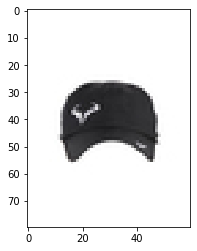

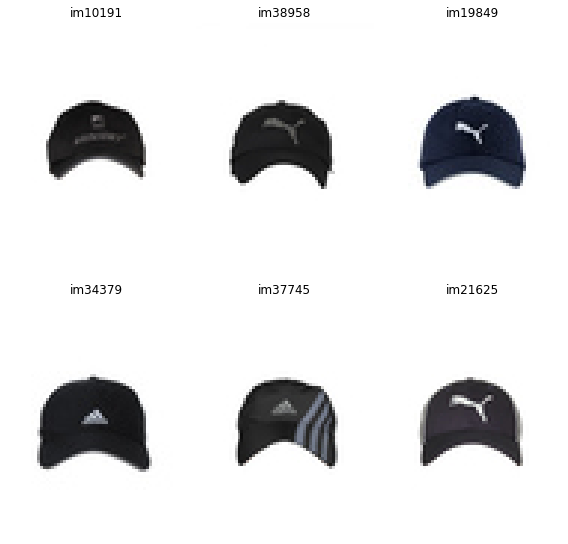

In [147]:
idx = 12122

idx_rec = get_rec_idx(idx,style)

plt.imshow(cv2.cvtColor(cv2.imread(style.iloc[idx].image), cv2.COLOR_BGR2RGB))

figures = {'im'+str(i): cv2.imread(row.image) for i, row in style.loc[idx_rec].iterrows()}

plotting(figures, 2, 3)

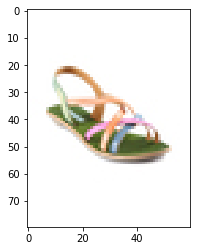

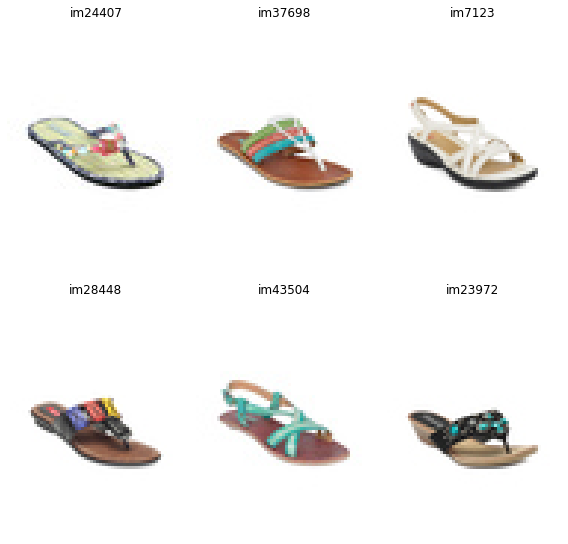

In [148]:
idx = 41252

idx_rec = get_rec_idx(idx,style)

plt.imshow(cv2.cvtColor(cv2.imread(style.iloc[idx].image), cv2.COLOR_BGR2RGB))

figures = {'im'+str(i): cv2.imread(row.image) for i, row in style.loc[idx_rec].iterrows()}

plotting(figures, 2, 3)

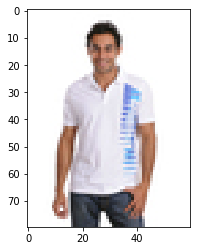

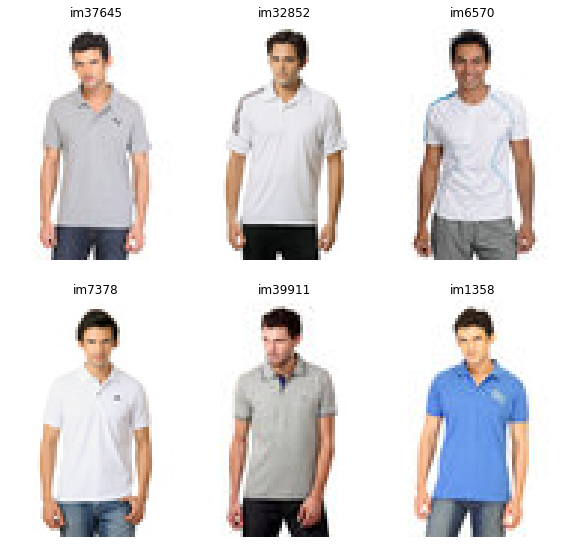

In [149]:
idx = 30299

idx_rec = get_rec_idx(idx,style)

plt.imshow(cv2.cvtColor(cv2.imread(style.iloc[idx].image), cv2.COLOR_BGR2RGB))

figures = {'im'+str(i): cv2.imread(row.image) for i, row in style.loc[idx_rec].iterrows()}

plotting(figures, 2, 3)